In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

DATA_BASE_PATH = "./malimg_paper_dataset_imgs/"

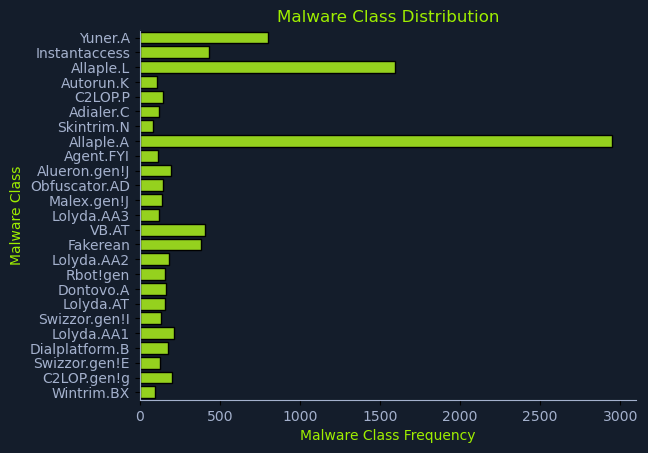

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

DATA_BASE_PATH = "./malimg_paper_dataset_imgs/"

dist = {}
for mlw_class in os.listdir(DATA_BASE_PATH):
    mlw_dir = os.path.join(DATA_BASE_PATH, mlw_class)
    dist[mlw_class] = len(os.listdir(mlw_dir))

htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

classes = list(dist.keys())
frequencies = list(dist.values())

plt.figure(facecolor=node_black)
sns.barplot(y=classes, x=frequencies, edgecolor="black", orient='h', color=htb_green)
plt.title("Malware Class Distribution", color=htb_green)
plt.xlabel("Malware Class Frequency", color=htb_green)
plt.ylabel("Malware Class", color=htb_green)
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
plt.show()


In [4]:
import splitfolders

DATA_BASE_PATH = "./malimg_paper_dataset_imgs/"
TARGET_BASE_PATH = "./newdata/"

TRAINING_RATIO = 0.8
TEST_RATIO = 1 - TRAINING_RATIO

splitfolders.ratio(
    input=DATA_BASE_PATH, 
    output=TARGET_BASE_PATH, 
    ratio=(TRAINING_RATIO, 0, TEST_RATIO)
)


Copying files: 9339 files [00:17, 545.41 files/s] 


In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
from torchvision.datasets import ImageFolder
import os

BASE_PATH = "./newdata/"

train_dataset = ImageFolder(
    root=os.path.join(BASE_PATH, "train"),
    transform=transform
)

test_dataset = ImageFolder(
    root=os.path.join(BASE_PATH, "test"),
    transform=transform
)

train_dataset, test_dataset


(Dataset ImageFolder
     Number of datapoints: 7459
     Root location: ./newdata/train
     StandardTransform
 Transform: Compose(
                Resize(size=(75, 75), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 1880
     Root location: ./newdata/test
     StandardTransform
 Transform: Compose(
                Resize(size=(75, 75), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [7]:
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1171243].


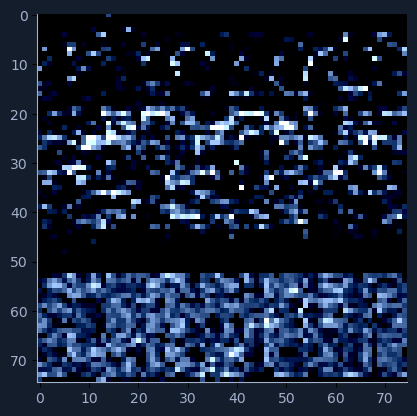

In [8]:
import matplotlib.pyplot as plt

# HTB colors (optional)
htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

sample = next(iter(train_loader))[0][0]

plt.figure(facecolor=node_black)
plt.imshow(sample.permute(1,2,0))
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, n_epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model.to(device)

    # Only parameters in final layer will update
    optimizer = optim.Adam(model.resnet.fc.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Evaluate on test set
        test_acc = evaluate_model(model, test_loader, device)

        print(f"Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


In [10]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

def load_datasets(base_path, train_batch_size, test_batch_size):
    # Define preprocessing transforms
    transform = transforms.Compose([
        transforms.Resize((75, 75)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load training and test datasets
    train_dataset = ImageFolder(
        root=os.path.join(base_path, "train"),
        transform=transform
    )

    test_dataset = ImageFolder(
        root=os.path.join(base_path, "test"),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    n_classes = len(train_dataset.classes)
    return train_loader, test_loader, n_classes


In [14]:
import torch.nn as nn
import torchvision.models as models

HIDDEN_LAYER_SIZE = 1000

class MalwareClassifier(nn.Module):
    def __init__(self, n_classes):
        super(MalwareClassifier, self).__init__()
        
        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights='DEFAULT')
        
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace final FC layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, HIDDEN_LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_SIZE, n_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [15]:
DATA_PATH = "./newdata/"
TRAINING_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Load data
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Create model
model = MalwareClassifier(n_classes)

# Train it
train_model(model, train_loader, test_loader, n_epochs=5, lr=0.001)


Using device: cpu
Epoch 1/5 | Loss: 15.2650 | Train Acc: 45.29% | Test Acc: 44.31%
Epoch 2/5 | Loss: 6.0541 | Train Acc: 78.74% | Test Acc: 53.03%
Epoch 3/5 | Loss: 3.3273 | Train Acc: 87.93% | Test Acc: 61.65%
Epoch 4/5 | Loss: 2.3347 | Train Acc: 90.36% | Test Acc: 66.97%
Epoch 5/5 | Loss: 1.9697 | Train Acc: 91.70% | Test Acc: 68.94%


In [16]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models


In [17]:
def load_datasets(base_path, train_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.Resize((75, 75)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_dataset = ImageFolder(
        root=os.path.join(base_path, "train"),
        transform=transform
    )

    test_dataset = ImageFolder(
        root=os.path.join(base_path, "test"),
        transform=transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    n_classes = len(train_dataset.classes)
    return train_loader, test_loader, n_classes


In [18]:
HIDDEN_LAYER_SIZE = 1000

class MalwareClassifier(nn.Module):
    def __init__(self, n_classes):
        super(MalwareClassifier, self).__init__()
        
        self.resnet = models.resnet50(weights="DEFAULT")

        # Freeze pretrained layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, HIDDEN_LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_SIZE, n_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [19]:
def compute_accuracy(n_correct, n_total):
    return round(100 * n_correct / n_total, 2)

def train(model, train_loader, n_epochs, verbose=False):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    training_data = {"accuracy": [], "loss": []}

    for epoch in range(n_epochs):
        running_loss = 0
        n_total = 0
        n_correct = 0
        start = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            n_total += labels.size(0)
            n_correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = compute_accuracy(n_correct, n_total)
        training_data["accuracy"].append(epoch_acc)
        training_data["loss"].append(epoch_loss)

        if verbose:
            print(f"[i] Epoch {epoch+1}/{n_epochs}: Acc={epoch_acc}%, Loss={epoch_loss:.4f}, Time={int((time.time()-start)*1000)}ms")

    return training_data


In [20]:
def predict(model, inputs):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
    return predicted

def evaluate(model, test_loader):
    model.eval()
    n_correct = 0
    n_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            predicted = predict(model, inputs)
            n_total += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    return compute_accuracy(n_correct, n_total)


In [21]:
def save_model(model, path):
    scripted = torch.jit.script(model)
    scripted.save(path)


In [22]:
def plot(data, title, label, xlabel, ylabel):
    htb_green = "#9FEF00"
    node_black = "#141D2B"
    hacker_grey = "#A4B1CD"

    plt.figure(figsize=(10,6), facecolor=node_black)
    plt.plot(range(1, len(data)+1), data, label=label, color=htb_green)
    plt.title(title, color=htb_green)
    plt.xlabel(xlabel, color=htb_green)
    plt.ylabel(ylabel, color=htb_green)
    plt.xticks(color=hacker_grey)
    plt.yticks(color=hacker_grey)

    ax = plt.gca()
    ax.set_facecolor(node_black)
    ax.spines['bottom'].set_color(hacker_grey)
    ax.spines['top'].set_color(node_black)
    ax.spines['right'].set_color(node_black)
    ax.spines['left'].set_color(hacker_grey)

    legend = plt.legend(facecolor=node_black, edgecolor=hacker_grey)
    plt.setp(legend.get_texts(), color=htb_green)
    plt.show()

def plot_training_accuracy(info):
    plot(info["accuracy"], "Training Accuracy", "Accuracy", "Epoch", "Accuracy (%)")

def plot_training_loss(info):
    plot(info["loss"], "Training Loss", "Loss", "Epoch", "Loss")


[i] Starting Training...
[i] Epoch 1/10: Acc=58.67%, Loss=1.4595, Time=439290ms
[i] Epoch 2/10: Acc=86.34%, Loss=0.4287, Time=447712ms
[i] Epoch 3/10: Acc=90.79%, Loss=0.2662, Time=439156ms
[i] Epoch 4/10: Acc=92.47%, Loss=0.2122, Time=440824ms
[i] Epoch 5/10: Acc=93.75%, Loss=0.1733, Time=447004ms
[i] Epoch 6/10: Acc=94.76%, Loss=0.1489, Time=443922ms
[i] Epoch 7/10: Acc=95.72%, Loss=0.1407, Time=452496ms
[i] Epoch 8/10: Acc=96.61%, Loss=0.1126, Time=448280ms
[i] Epoch 9/10: Acc=96.39%, Loss=0.1143, Time=453023ms
[i] Epoch 10/10: Acc=97.16%, Loss=0.0911, Time=455088ms
[i] Final Accuracy: 88.62%


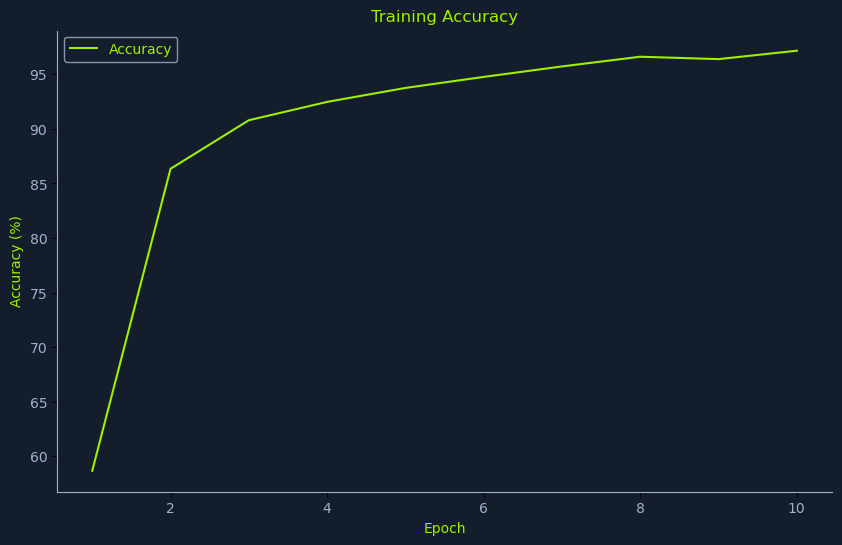

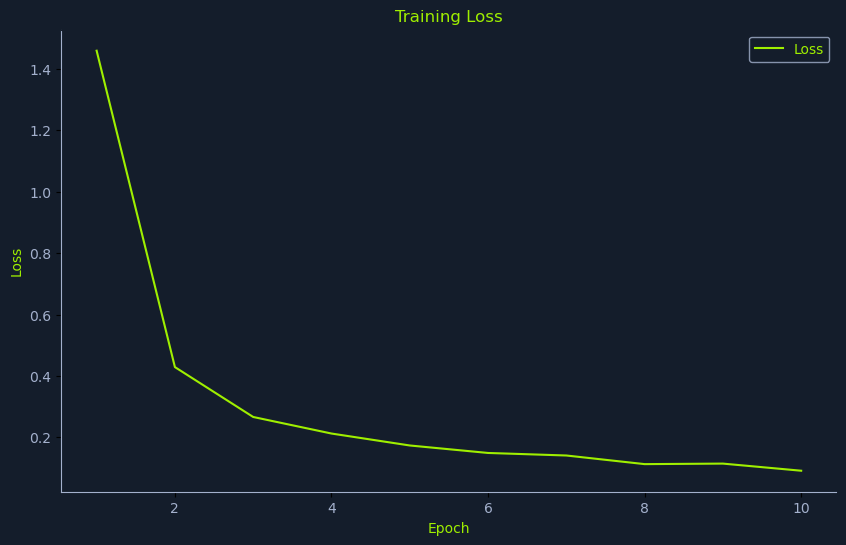

In [23]:
# data parameters
DATA_PATH = "./newdata/"

# training parameters
N_EPOCHS = 10
TRAINING_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1024

# model parameters
MODEL_FILE = "malware_classifier.pth"

# Load data
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Create model
model = MalwareClassifier(n_classes)

# Train model
print("[i] Starting Training...")
training_info = train(model, train_loader, N_EPOCHS, verbose=True)

# Save model
save_model(model, MODEL_FILE)

# Evaluate
accuracy = evaluate(model, test_loader)
print(f"[i] Final Accuracy: {accuracy}%")

# Plots
plot_training_accuracy(training_info)
plot_training_loss(training_info)


In [24]:
import matplotlib.pyplot as plt

def plot(data, title, label, xlabel, ylabel):
    # HTB Color Palette
    htb_green = "#9FEF00"
    node_black = "#141D2B"
    hacker_grey = "#A4B1CD"

    # plot
    plt.figure(figsize=(10, 6), facecolor=node_black)
    plt.plot(range(1, len(data)+1), data, label=label, color=htb_green)
    plt.title(title, color=htb_green)
    plt.xlabel(xlabel, color=htb_green)
    plt.ylabel(ylabel, color=htb_green)
    plt.xticks(color=hacker_grey)
    plt.yticks(color=hacker_grey)
    ax = plt.gca()
    ax.set_facecolor(node_black)
    ax.spines['bottom'].set_color(hacker_grey)
    ax.spines['top'].set_color(node_black)
    ax.spines['right'].set_color(node_black)
    ax.spines['left'].set_color(hacker_grey)

    legend = plt.legend(facecolor=node_black, edgecolor=hacker_grey, fontsize=10)
    plt.setp(legend.get_texts(), color=htb_green)
    
    plt.show()

def plot_training_accuracy(training_data):
    plot(training_data['accuracy'], "Training Accuracy", "Accuracy", "Epoch", "Accuracy (%)")

def plot_training_loss(training_data):
    plot(training_data['loss'], "Training Loss", "Loss", "Epoch", "Loss")

In [27]:
print("Starting tiny test...")
test = train(model, train_loader, 1, verbose=True)
print("Tiny test finished.")


Starting tiny test...
[i] Epoch 1/1: Acc=93.82%, Loss=0.1572, Time=446973ms
Tiny test finished.


In [28]:
save_model(model, "malware_classifier.pth")


In [29]:
import requests
import json

url = "http://localhost:8002/api/upload"
model_file_path = "malware_classifier.pth"

with open(model_file_path, "rb") as f:
    files = {"model": f}
    response = requests.post(url, files=files)

print(json.dumps(response.json(), indent=4))

{
    "accuracy": 0.9403425871234495,
    "flag": "HTB{9569648083a8106ba057bbbe2d00d8ec}"
}
